In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
from tqdm import tqdm

In [3]:
# Charger les données
interactions = pd.read_csv("data_final_project/KuaiRec 2.0/data/small_matrix.csv")
kuairec_caption_category = pd.read_csv(
    "data_final_project/KuaiRec 2.0/data/kuairec_caption_category.csv",
    engine="python", sep=",", quotechar='"', on_bad_lines='skip'
)
item_categories = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_categories.csv")
item_daily_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_daily_features.csv")
social_network = pd.read_csv("data_final_project/KuaiRec 2.0/data/social_network.csv")
user_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/user_features.csv")

In [33]:
# Explorer les données
print("\n--- INTERACTIONS ---\n")
print(f"Dimensions: {interactions.shape}\n")
print(interactions.info())
print("\n")
print("Nb videos uniques:", interactions['video_id'].nunique())
print("Nb users uniques:", interactions['user_id'].nunique())


--- INTERACTIONS ---

Dimensions: (4676570, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4676570 entries, 0 to 4676569
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1   video_id        int64  
 2   play_duration   int64  
 3   video_duration  int64  
 4   time            object 
 5   date            float64
 6   timestamp       float64
 7   watch_ratio     float64
dtypes: float64(3), int64(4), object(1)
memory usage: 285.4+ MB
None


Nb videos uniques: 3327
Nb users uniques: 1411


In [26]:
print("\n--- ITEM_CATEGORIES ---\n")
print(f"Dimensions: {item_categories.shape}")
display(item_categories.head())
print("Nb videos uniques:", item_categories['video_id'].nunique())


--- ITEM_CATEGORIES ---

Dimensions: (10728, 2)


,video_id,feat
0,0,[8]
1,1,"[27, 9]"
2,2,[9]
3,3,[26]
4,4,[5]


Nb videos uniques: 10728


In [27]:
print("\n--- KUAIREC CAPTION CATEGORY ---\n")
print(f"Dimensions: {kuairec_caption_category.shape}\n")
display(kuairec_caption_category.head())
print("\n")
print("Distribution des catégories principales:")
if 'first_level_category_name' in kuairec_caption_category.columns:
    print(kuairec_caption_category['first_level_category_name'].value_counts().head(10))

print("\n")
print(kuairec_caption_category.dtypes)
print("\nNb vidéos uniques:", kuairec_caption_category['video_id'].nunique()) 


--- KUAIREC CAPTION CATEGORY ---

Dimensions: (10732, 10)



,video_id,manual_cover_text,caption,topic_tag,first_level_category_id,first_level_category_name,second_level_category_id,second_level_category_name,third_level_category_id,third_level_category_name
0,0,UNKNOWN,精神小伙路难走 程哥你狗粮慢点撒,[],8.0,颜值,673.0,颜值随拍,-124.0,UNKNOWN
1,1,UNKNOWN,NaN,[],27.0,高新数码,-124.0,UNKNOWN,-124.0,UNKNOWN
2,2,UNKNOWN,晚饭后，运动一下！,[],9.0,喜剧,727.0,搞笑互动,-124.0,UNKNOWN
3,3,UNKNOWN,我平淡无奇，惊艳不了时光，温柔不了岁月，我只想漫无目的的走走，努力发笔小财，给自己买花 自己长大.,[],26.0,摄影,686.0,主题摄影,2434.0,景物摄影
4,4,五爱街最美美女 一天1q,#搞笑 #感谢快手我要上热门 #五爱市场 这真是完美搭配啊！,"[五爱市场,感谢快手我要上热门,搞笑]",5.0,时尚,737.0,营销售卖,2596.0,女装




Distribution des catégories principales:
first_level_category_name
民生资讯    1095
时尚      1034
其他       913
颜值       824
情感       532
美食       475
明星娱乐     471
舞蹈       422
生活       417
自拍       379
Name: count, dtype: int64


video_id                       object
manual_cover_text              object
caption                        object
topic_tag                      object
first_level_category_id       float64
first_level_category_name      object
second_level_category_id      float64
second_level_category_name     object
third_level_category_id       float64
third_level_category_name      object
dtype: object

Nb vidéos uniques: 10730


In [28]:
print("\n--- ITEM DAILY FEATURES ---\n")
print(f"Dimensions: {item_daily_features.shape}")
display(item_daily_features.head())
print("Métriques d'engagement moyennes:")
engagement_cols = ['play_cnt', 'like_cnt', 'comment_cnt', 'share_cnt']
print(item_daily_features[engagement_cols].describe())

print("\nNb valeurs de video_id:", item_daily_features['video_id'].nunique())


--- ITEM DAILY FEATURES ---

Dimensions: (343341, 58)


,video_id,date,author_id,video_type,upload_dt,upload_type,visible_status,video_duration,video_width,video_height,...,download_cnt,download_user_num,report_cnt,report_user_num,reduce_similar_cnt,reduce_similar_user_num,collect_cnt,collect_user_num,cancel_collect_cnt,cancel_collect_user_num
0,0,20200705,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,...,8,8,0,0,3,3,NaN,NaN,NaN,NaN
1,0,20200706,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,...,2,2,0,0,5,5,NaN,NaN,NaN,NaN
2,0,20200707,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,...,2,2,0,0,0,0,NaN,NaN,NaN,NaN
3,0,20200708,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,...,3,3,0,0,3,3,NaN,NaN,NaN,NaN
4,0,20200709,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,...,2,2,2,1,1,1,NaN,NaN,NaN,NaN


Métriques d'engagement moyennes:
           play_cnt      like_cnt    comment_cnt      share_cnt
count  3.433410e+05  3.433410e+05  343341.000000  343341.000000
mean   9.418781e+04  2.781109e+03     130.480764      80.380860
std    5.933298e+05  1.869603e+04    1565.610155    1284.173127
min    0.000000e+00  0.000000e+00       0.000000       0.000000
25%    1.400000e+01  0.000000e+00       0.000000       0.000000
50%    6.280000e+02  9.000000e+00       0.000000       0.000000
75%    2.067100e+04  4.210000e+02       9.000000       3.000000
max    4.116795e+07  2.673037e+06  182959.000000  299286.000000

Nb valeurs de video_id: 10728


In [30]:
print("\n--- SOCIAL NETWORK ---\n")
print(f"Dimensions: {social_network.shape}")
display(social_network.head(1000))


--- SOCIAL NETWORK ---

Dimensions: (472, 2)


,user_id,friend_list
0,3371,[2975]
1,24,[2665]
2,4402,[38]
3,4295,[4694]
4,7087,[7117]
...,...,...
467,2331,[4345]
468,6163,[1332]
469,3732,[670]
470,3335,[202]


In [32]:
print("\n--- USER FEATURES ---\n")
print(f"Dimensions: {user_features.shape}")
display(user_features.head())
print("Distribution de l'activité des utilisateurs:")
if 'user_active_degree' in user_features.columns:
    print(user_features['user_active_degree'].value_counts())

print("\nNb valeurs de user_id:", user_features['user_id'].nunique())


--- USER FEATURES ---

Dimensions: (7176, 31)


,user_id,user_active_degree,is_lowactive_period,is_live_streamer,is_video_author,follow_user_num,follow_user_num_range,fans_user_num,fans_user_num_range,friend_user_num,...,onehot_feat8,onehot_feat9,onehot_feat10,onehot_feat11,onehot_feat12,onehot_feat13,onehot_feat14,onehot_feat15,onehot_feat16,onehot_feat17
0,0,high_active,0,0,0,5,"(0,10]",0,0,0,...,184,6,3,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,full_active,0,0,0,386,"(250,500]",4,"[1,10)",2,...,186,6,2,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,full_active,0,0,0,27,"(10,50]",0,0,0,...,51,2,3,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,full_active,0,0,0,16,"(10,50]",0,0,0,...,251,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,full_active,0,0,0,122,"(100,150]",4,"[1,10)",0,...,99,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0


Distribution de l'activité des utilisateurs:
user_active_degree
full_active      6092
high_active       938
UNKNOWN           118
middle_active      28
Name: count, dtype: int64

Nb valeurs de user_id: 7176


In [ ]:
# Analyser les interactions
print("\n--- Analyse des interactions ---")
print("Nombre d'utilisateurs uniques:", interactions['user_id'].nunique())
print("Nombre de vidéos uniques:", interactions['video_id'].nunique())
print("Nombre total d'interactions:", len(interactions))
print("Densité de la matrice utilisateur-item:", 
      len(interactions) / (interactions['user_id'].nunique() * interactions['video_id'].nunique()))
# Densité = Nombre d'interactions / (Nombre d'utilisateurs * Nombre de vidéos) 
# = 1 si chaque utilisateur a interagi avec chaque vidéo



--- Analyse des interactions ---
Nombre d'utilisateurs uniques: 1411
Nombre de vidéos uniques: 3327
Nombre total d'interactions: 4676570
Densité de la matrice utilisateur-item: 0.9962024941648523


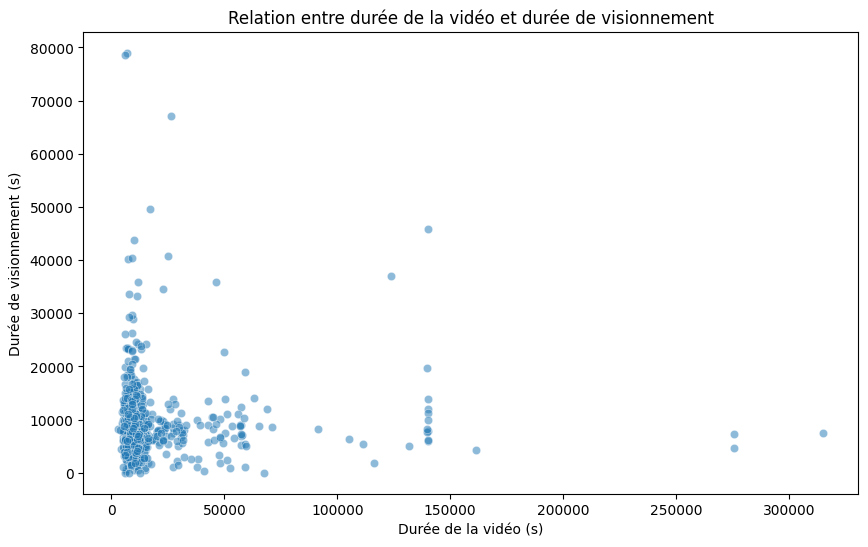

In [10]:
# Analyser les ratios de visionnement
if 'watch_ratio' in interactions.columns:   
    # Relation entre durée de visionnement et durée de la vidéo
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=interactions.sample(1000), x='video_duration', y='play_duration', alpha=0.5)
    plt.title('Relation entre durée de la vidéo et durée de visionnement')
    plt.xlabel('Durée de la vidéo (s)')
    plt.ylabel('Durée de visionnement (s)')
    plt.savefig('play_vs_video_duration.png')
    plt.show()

In [11]:
# Analyser les vidéos les plus populaires
print("\n--- Top 10 des vidéos les plus regardées ---")
video_popularity = interactions.groupby('video_id').size().sort_values(ascending=False)
print(video_popularity.head(10))



--- Top 10 des vidéos les plus regardées ---
video_id
9804     1411
4106     1411
4125     1411
4123     1411
4122     1411
4121     1411
4120     1411
4119     1411
10067    1411
4114     1411
dtype: int64


In [12]:
# Analyser les utilisateurs les plus actifs
print("\n--- Top 10 des utilisateurs les plus actifs ---")
user_activity = interactions.groupby('user_id').size().sort_values(ascending=False)
print(user_activity.head(10))


--- Top 10 des utilisateurs les plus actifs ---
user_id
4681    3327
6886    3327
5149    3327
3201    3327
1834    3327
5339    3327
6122    3327
7018    3327
137     3326
2007    3326
dtype: int64


In [13]:
# Vérifier s'il y a des valeurs manquantes
print("\n--- Valeurs manquantes dans les données ---")
print("Interactions:", interactions.isnull().sum().sum())
print("Catégories d'items:", item_categories.isnull().sum().sum())
print("Catégories et légendes:", kuairec_caption_category.isnull().sum().sum())
print("Caractéristiques quotidiennes des items:", item_daily_features.isnull().sum().sum())
print("Réseau social:", social_network.isnull().sum().sum())
print("Caractéristiques utilisateurs:", user_features.isnull().sum().sum())


--- Valeurs manquantes dans les données ---
Interactions: 545976
Catégories d'items: 0
Catégories et légendes: 1392
Caractéristiques quotidiennes des items: 321764
Réseau social: 0
Caractéristiques utilisateurs: 650
